# [Collision Avoidance Challenge](https://kelvins.esa.int/collision-avoidance-challenge/home/)
## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns

| Column      | Description |
| :---------: | :---------- |
| `risk`|self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**|
| `event_id`| Unique id per collision event|
| `time_to_tca`| Time interval between CDM creation and time-of-closest approach [days]|
| `mission_id`| Identifier of mission that will be affected|
| `max_risk_estimate`| Maximum collision probability obtained by scaling combined covariance|
| `max_risk_scaling`| Scaling factor used to compute maximum collision probability|
| `miss_distance`| Relative position between chaser & target at tca [m]|
| `relative_speed`| Relative speed between chaser & target at tca [m/s]|
| `relative_position_n`| Relative position between chaser & target: normal (cross-track) [m]|
| `relative_position_r`| Relative position between chaser & target: radial [m]|
| `relative_position_t`| Relative position between chaser & target: transverse (along-track) [m]|
| `relative_velocity_n`| Relative velocity between chaser & target: normal (cross-track) [m/s]|
| `relative_velocity_r`| Relative velocity between chaser & target: radial [m/s]|
| `relative_velocity_t`| Relative velocity between chaser & target: transverse (along-track) [m/s]|
| `c_object_type`| Object type which is at collision risk with satellite|
| `geocentric_latitude`| Latitude of conjunction point [deg]|
| `azimuth`| Relative velocity vector: azimuth angle [deg]|
| `elevation`| Relative velocity vector: elevation angle [deg]|
| `F10`| 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]|
| `AP`| Daily planetary geomagnetic amplitude index|
| `F3M`| 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]|
| `SSN`| Wolf sunspot number|

#### Shared Column Names Between the Chaser and the Target Object
| Column      | Description |
| :---------: | :---------- |
 | `x_sigma_rdot`| Covariance; radial velocity standard deviation (sigma) [m/s]
 | `x_sigma_n`| Covariance; (cross-track) position standard deviation (sigma) [m]
 | `x_cn_r`| Covariance; correlation of normal (cross-track) position vs radial position
 | `x_cn_t`| Covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 | `x_cndot_n`| Covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 | `x_sigma_ndot`| Covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 | `x_cndot_r`| Covariance; correlation of normal (cross-track) velocity vs radial position
 | `x_cndot_rdot`| Covariance; correlation of normal (cross-track) velocity vs radial velocity
 | `x_cndot_t`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 | `x_cndot_tdot`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 | `x_sigma_r`| Covariance; radial position standard deviation (sigma) [m]
 | `x_ct_r`| Covariance; correlation of transverse (along-track) position vs radial position
 | `x_sigma_t`| Covariance; transverse (along-track) position standard deviation (sigma) [m]
 | `x_ctdot_n`| Covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 | `x_crdot_n`| Covariance; correlation of radial velocity vs normal (cross-track) position
 | `x_crdot_t`| Covariance; correlation of radial velocity vs transverse (along-track) position
 | `x_crdot_r`| Covariance; correlation of radial velocity vs radial position
 | `x_ctdot_r`| Covariance; correlation of transverse (along-track) velocity vs radial position
 | `x_ctdot_rdot`| Covariance; correlation of transverse (along-track) velocity vs radial velocity
 | `x_ctdot_t`| Covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 | `x_sigma_tdot`| Covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 | `x_position_covariance_det`| Determinant of covariance (~volume)
 | `x_cd_area_over_mass`| Ballistic coefficient [m2m2/kg]
| `x_cr_area_over_mass`| Solar radiation coefficient . A/m (ballistic coefficient equivalent)
 | `x_h_apo`| Apogee (-RearthRearth) [km]
 | `x_h_per`| Perigee (-RearthRearth)[km]
 | `x_j2k_ecc`| Eccentricity
 | `x_j2k_inc`| Inclination [deg]
 | `x_j2k_sma`| Semi-major axis [km]
 | `x_sedr`| Energy dissipation rate [W/kg]
 | `x_span`| Size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 | `x_rcs_estimate`| Radar cross-sectional area [m2m2]
 | `x_actual_od_span`| Actual length of update interval for orbit determination [days]
 | `x_obs_available`| Number of observations available for orbit determination (per CDM)
 | `x_obs_used`| Number of observations used for orbit determination (per CDM)
 | `x_recommended_od_span`| Recommended length of update interval for orbit determination [days]
 | `x_residuals_accepted`| Orbit determination residuals
 | `x_time_lastob_end`| End of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_time_lastob_start`| Start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_weighted_rms`| Root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)

The development of any Machine Learning model requires a solid knowledge of the data available for its training and subsequent development in order to guarantee a successful deployment and applicability to real-world problems. For this purpose, in this section we develop a comprehensive *Exploratory Data Analysis* (EDA) on the Kelvins Collision Avoidance Challenge `training` and `test` datasets with two main objectives in mind:
 - Acquire a solid understanding of real data received in a conventional Conjunction Data Message (CDM); this involves a basic analysis of the data distribution and its potential common patterns for ***Target*** and ***Chaser*** objects, and cluster identification for conjunction events.
 
- Develop a Synthetic Data Generation (SDG) process that can reliably produce additional virtual (non-existing) data with the objective to enrich the Time-Series Forecasting Deep Learning model and improve its performance in production by reinforcing its training process.

For this purpose, this notebook is structured in the following sections:

1. Data import and initial exploration.
2. Data distribution analysis.
3. Synthetic data generation using estimated Probability Densities computed with Parametric and Non-Parametric approaches.
4. Virtual Conjunction Data Message (CDM) creation

## Required libraries
All the relevant libraries required to perform the EDA, SDG, and CDM creation in this notebook are imported in the code block below:

In [1]:
# Import libraries required for EDA
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os
import warnings
import requests
import time
import json

# Import Scikit-learn required libraries
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score

# Import function to clear output
from IPython.display import clear_output

# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc, gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 

# Define list of colors for charts
colors_list = list(mcolors.TABLEAU_COLORS.values())

# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

## Custom functions
### General purpose functions

In [2]:
def outliers_boundaries(data, threshold = 1.5):
    """Compute limits of standard data within a given data distribution."""
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = st.iqr(data)
    
    return (max(0, (Q1-IQR*threshold)), (Q3+IQR*threshold))

def nbins(data, rule):
    """Estimate adequate number of bins for histograms."""
    
    # Get the number of items within the dataset
    n = len(data)
    
    # Compute the histogram bins size (range)
    bins_width = {'sturge': 1 + 3.322*np.log(n),    
                 'scott': 3.49*np.std(data)*n**(-1/3),                       
                 'rice': 2*n**(1/3),                         
                 'fd': 2*st.iqr(data)*n**(-1/3)}
    
    # Compute number of bins
    n_bins =  math.ceil((data.max() - data.min())/bins_width[rule])
    
    return {'n': n_bins, 'width':bins_width}

# Define function to round by magnitude order.
def round_by_mo(value, method='ceil', threshold=1.0):
    """Round up/down float using its order of magnitude given a threshold."""
    
    # Return 0 if value is 0
    if value==0: return 0
    
    # Compute order of magnitude
    om = 10**(math.floor(math.log(value, 10)))
    methods = {'ceil':math.ceil, 'floor':math.floor}
    
    threshold = threshold if method=='floor' else threshold-1
    if method in ['ceil', 'floor']:
        return (methods[method](value/om)+threshold)*om
    else:
        return None 

### Statistics based custom functions

The process to fit a parametric probability density estimation follows a series of steps for which it is convenient to develop segregated functions. For this purpose, the following functions are defined:
 - `fit_distribution`: Fits a statistical continuous distribution to the input data. It returns the distribution, its parameters adjusted, and the resulting SSE.
 - `make_pdf`: It creates an array to represent the probability density function using a given fitted distribution and its parameters.
 - `plot_dist`: Plots the probability density function and the data distribution histogram on a single chart for a visual interpretation of the probability density estimation. It supports the reader/data analyst to check appropriate fitting; some distributions may return low SSE but does not appropriately describe de distribution.

In [3]:
def get_scipy_distributions():
    """Get list of continuous distributions from SciPy.org website"""
    try:
        # Get Continuous distributions table from SciPy website.
        url = 'https://docs.scipy.org/doc/scipy/reference/stats.html'
        tbody = pd.read_html(requests.get(url).content)[1]
        
        # Create pandas dataframe and save CSV local file to be able to use the notebook offline.
        df_distributions = pd.DataFrame(data = tbody[0].to_list(), columns=['scipy_distributions'])
        df_distributions.to_csv(os.path.join(cwd,'temp_scipy-distributions.csv'), sep=',')
        
    except Exception:
        print("Could not read SciPy.org website. Importing data from local file...")
        # Import training dataset
        df_distributions = pd.read_csv(os.path.join(cwd,'data','notebook-outputs','temp_scipy-distributions.csv'), 
                            sep=',', header=0, index_col=None, skipinitialspace=False)

        pass
    
    # Evaluate list of objects in str format to convert it into a Python list
    distributions_list = []
    
    # Iterate through all the continous distributions on the website and evaluate it
    # to discard those that are not compatible with the library version installed.
    for distribution_i in df_distributions['scipy_distributions'].to_list():
        try:
            distributions_list.append(eval('st.' + distribution_i))
            print(distribution_i)
        except Exception:
            pass

    return distributions_list

In [17]:
class FitScipyDistribution:
    def __init__(self, data, distribution):
        self.dist = distribution
        self.data = data
        self.name = distribution.name
        
        # Try to fit the distribution
        tic = time.process_time()
        
        # Separate parts of parameters
        try:
            # Ignore warnings from data that can"t be fit
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                # Fit dist to data
                fitting_output = distribution.fit(data)

                # Separate parts of parameters
                params = {'loc':   fitting_output[-2], 
                          'scale': fitting_output[-1],
                          'arg_values': [],
                         'arg_names': []}
                
                if distribution.shapes!=None: 
                    params['arg_names']  = distribution.shapes.split(", ") 
                    params['arg_values'] = list(fitting_output[:-2])
                    
                params['names'] = params['arg_names'] + ['loc', 'scale']
                params['values'] = params['arg_values'] + params['loc'] + params['scale']
                self.params = params

        except Exception:

            self.params = None
            pass
        
        toc = time.process_time()
        self.processing_time = toc-tic
        
        
    def r2_score(self):
        
        if self.params == None: return 0
        
        # Get histogram of original data
        y, bin_edges = np.histogram(self.data, bins=nbins(self.data,'fd')['n'], density=True)
        bin_centers = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0
        
        # Calculate fitted PDF and error with fit in distribution
        pdf = self.dist.pdf(bin_centers, loc=self.params['loc'], 
                            scale=self.params['scale'], 
                            *self.params['arg_values'])
        self.n_bins = len(bin_centers)
        self.bins_width = bin_edges[1]-bin_edges[0]
        try:
            r2 = r2_score(y, pdf)
        except Exception:
            r2 = 0
            pass
        
        return r2
    
    def pdf(self, size=10000):
        """Generate distributions's Probability Distribution Function"""
        
        if self.params == None: return None
        
        # Separate parts of parameters
        arg, loc, scale = self.params['arg_values'], self.params['loc'], self.params['scale']

        # Get same start and end points of distribution
        start = self.dist.ppf(1e-4, *arg, loc=loc, scale=scale) \
            if arg else self.dist.ppf(1e-4, loc=loc, scale=scale)
        end = self.dist.ppf(1-1e-4, *arg, loc=loc, scale=scale) \
            if arg else self.dist.ppf(1-1e-4, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = self.dist.pdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf
    


In [ ]:
def fit_distribution(distribution, data, bins):
    """Fit statistical distribution to a given array of data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Try to fit the distribution
    tic = time.process_time()
    try:
        # Ignore warnings from data that can"t be fit
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            # Fit dist to data
            fitting_output = distribution.fit(data)

            # Separate parts of parameters
            parameters = {'loc':        fitting_output[-2],
                          'scale':      fitting_output[-1],
                          'arg':        fitting_output[:-2],
                          'arg_names':  distribution.shapes.split(", ") if distribution.shapes!=None else []}
            
            parameters['names'] = parameters['arg_names'] + ["loc", "scale"]
            parameters['values'] = parameters['arg'] + parameters['loc'] + parameters['scale']
    
            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=parameters['loc'], scale=parameters['scale'], *parameters['arg'])
            r2 = r2_score(y, pdf)

    except Exception:
        
        parameters, r2 = None, 0
        pass
    
    toc = time.process_time()
    
    # identify if this distribution is better
    output = {'distribution': distribution, 'name': distribution.name, 
              'parameters': parameters, 'r2_score': r2}
    
    output['performance'] = {'processing_time': toc-tic, 'bins':bins}
    
    return output



In [ ]:
def scipy_pdf(distribution, parameters, size=10000):
    """Generate distributions's Probability Distribution Function"""
    # Separate parts of parameters
    arg     = parameters['arg']
    loc     = parameters['loc']
    scale   = parameters['scale']

    # Get same start and end points of distribution
    start = distribution.ppf(1e-4, *arg, loc=loc, scale=scale) \
        if arg else distribution.ppf(1e-4, loc=loc, scale=scale)
    end = distribution.ppf(1-1e-4, *arg, loc=loc, scale=scale) \
        if arg else distribution.ppf(1-1e-4, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = distribution.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [11]:
# Define function to 
def find_best_distribution(data, exclusion_list=[]):
    """Find best fitted distribution (higher R2 score vs actual probability density)"""
    # Evaluate list of objects in str format to convert it into a Python list
    stdists_list = get_scipy_distributions()
    
    # Initialize best holder using the norm distribution
    best_stdist = FitScipyDistribution(data, st.norm)
    
    fitting_results = []

    # Estimate distribution parameters from data
    for i, stdist_i in enumerate(stdists_list):
        
        # If statistical distribution is in the exclusion list skip fitting process.
        if stdist_i.name in exclusion_list: continue
        
        # Fit stdist to real data
        fitted_stdist = FitScipyDistribution(data, stdist_i)

        clear_output(wait=True)

        print('Progress %5.1f%% (%3d/%3d)  Best: %10s (R2: %0.2f)  Distribution: %10s (R2=%0.2f) \t' %
              ((i+1)/len(stdists_list)*100, i, len(stdists_list)-1, 
               best_stdist.name, best_stdist.r2_score(), 
               fitted_stdist.name, fitted_stdist.r2_score()), end='\r')
        
        # If it improves the current best distribution, reassign best distribution
        if best_stdist.r2_score() < fitted_stdist.r2_score(): best_stdist = fitted_stdist
        
        fitting_results.append([fitted_stdist.name, fitted_stdist.r2_score()])
        
    # Sort values of dataframe by sse ascending and and re-index.
    ranking = pd.DataFrame(data=fitting_results, columns=['distribution', 'r2_score'])
    ranking.sort_values(by=['r2_score'], axis='index', ascending=[False], 
                              inplace=True, ignore_index=True)
    
    # Clear output to print final results
    clear_output(wait=True)
    
    return best_stdist, ranking

In [24]:
def plot_scipy_pdf(data, pdf, bins, **kwargs):
    """Plot histogram and PDF based on a given distribution and its parameters"""
    
    # Display plot
    plt.figure(figsize=(7,3))
    
    if 'text' in kwargs.keys(): 
        ax = plt.axes()
        t=ax.text(0.5, 0.975, kwargs['text'], size=10, ha='center', va='top', 
                        c='black', transform=ax.transAxes, 
                        bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, pad=1))
    
    plt.plot(pdf.index.to_numpy(), pdf.values, lw=1.5, color = "orange", label="PDF")
    n, bin_edges, patches = plt.hist(data, bins=bins, density=True, histtype='bar', 
                                 color="dimgrey", edgecolor = "white", label="Data")
    
    bins_width = (bin_edges[1]-bin_edges[0])
    plt.xlim(bin_edges[0] - bins_width, bin_edges[-1] + bins_width)
    plt.ylim(0, np.max(n)*1.5)
    
    plt.title(r'Actual data distribution vs. fitted PDF', fontsize=12)
    if 'xlabel' in kwargs.keys(): plt.xlabel(r'' + kwargs['xlabel'])
    plt.ylabel(r"Probability density")
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc="best", fontsize=10)
    plt.show()
    
    return

## 1. - Data import and initial exploration

For the ease of the development of this notebook, the required Kelvins datasets (`training` and `test`) are stored in the same repository as the present notebook. In this section, both datasets are imported locally with the aim to explore the data provided in the competition and identify all those aspects relevant for the SDG, CDM creation processes and the Time-Series Forecasting problem.

In [7]:
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
df.head(10)

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.013826,0.007173,0.000051,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,7.373471e+05,4.429923e+16,4.057932,266.722309,137.617114,54366.864909,1.781418,46.612573,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.013487,0.009139,0.000060,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,1.141390e+05,4.378610e+16,3.526780,262.191819,56.070117,54082.067268,1.800959,46.595869,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.013357,0.007057,0.000060,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,4.696004e+04,4.369105e+16,3.362037,261.666544,37.497947,54027.391201,1.821940,46.592757,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,


As described in the introduction of Kelvins competition, both `training` and `test` datasets contain several CDMs per `event_id`, being the **last CDM** for a given `event_id` the one with the **most accurate collision probability risk estimation**. Following the same assumption for the *Keplerian Elements* measurements (most accurate data in the latest CDM received), a subset `df_lastCDM` from the origin datasets is created containing only the last CDM. 

This subset of data will be used in throghout the present notebook as it constitutes the baseline upon which a basic understanding on how population of ASOs is distributed across its different dimensions is acquired, allowing for additional virtual CDMs creation using the SDG process.

In [8]:
# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(10)

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.00,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.00,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.00,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.

## 2. - Keplerian elements and miss distance data distribution analysis

In order to generate synthetic data with similar features to the current ASOs population in the near Earth orbits it is crucial to analyse the Keplerian elements of the existing objects orbits. This analysis is performed on the two types of objects involved in the conjunction events (*Target* and *Chaser*). The Keplerian elements given in the Kelvins datasets are those with the following column names: :

| Column      | Description |
| :---------: | :---------- |
| `miss_distance`   | Miss distance (m)|
| `x_h_apo`   | Apogee altitude (Km)|
| `x_h_per`   | Perigee (Km)|
| `x_j2k_ecc` | Eccentricity |
| `x_j2k_inc` | Inclination (deg)|
| `x_j2k_sma` | Semi-major axis (Km) |

where the preffix `x` is replaced by `t` or `c` for *Target* and *Chaser* objects respectively.


### 2.1. - Miss distance data distribution analysis

The starting point for the EDA and the SDG process is the analysis of the `miss_distance` as it clearly shows how frequent high-risk events take place among all conjunctions received. By analysing the `miss_distance` data distribution it is possible increase the frequency of conjunctions throughout time while ensuring reliability of data. To do so, we first have a look to the data distribution using an histogram plot as follows:

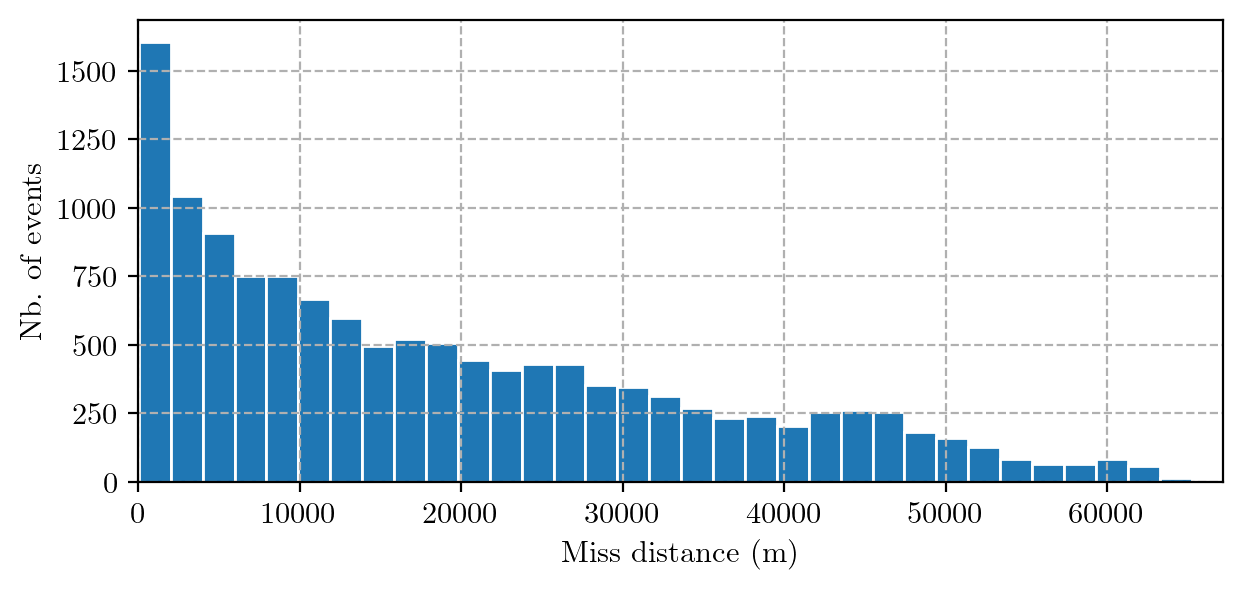

In [40]:
# Get data to plot
data = df_lastCDM['miss_distance'].to_numpy()

# Plot histogram of miss_distance
plt.figure(figsize=(7,3))
plt.hist(data, bins = nbins(data, 'fd')['n'], edgecolor='white')
plt.xlim(0, data.max())
plt.ylabel(r'Nb. of events')
plt.xlabel(r'Miss distance (m)')
plt.grid(True, linestyle='--')
plt.show()

### 2.2. - Keplerian elements data distribution analysis

In addition to the `miss_distance` data, the Keplerian elements data for both *Target* and *Chaser* objects are crucial in order to create virtual orbits from which new virtual CDMs can be created. The Keplerian elements to be considered are the following:
 - Perigee
 - Semi-major axis
 - Inclination
 - Eccentricity
 
It is noteworthy to mention that the apogee is not required as it will be considered to be dependent on the perigee and semi-major axis.

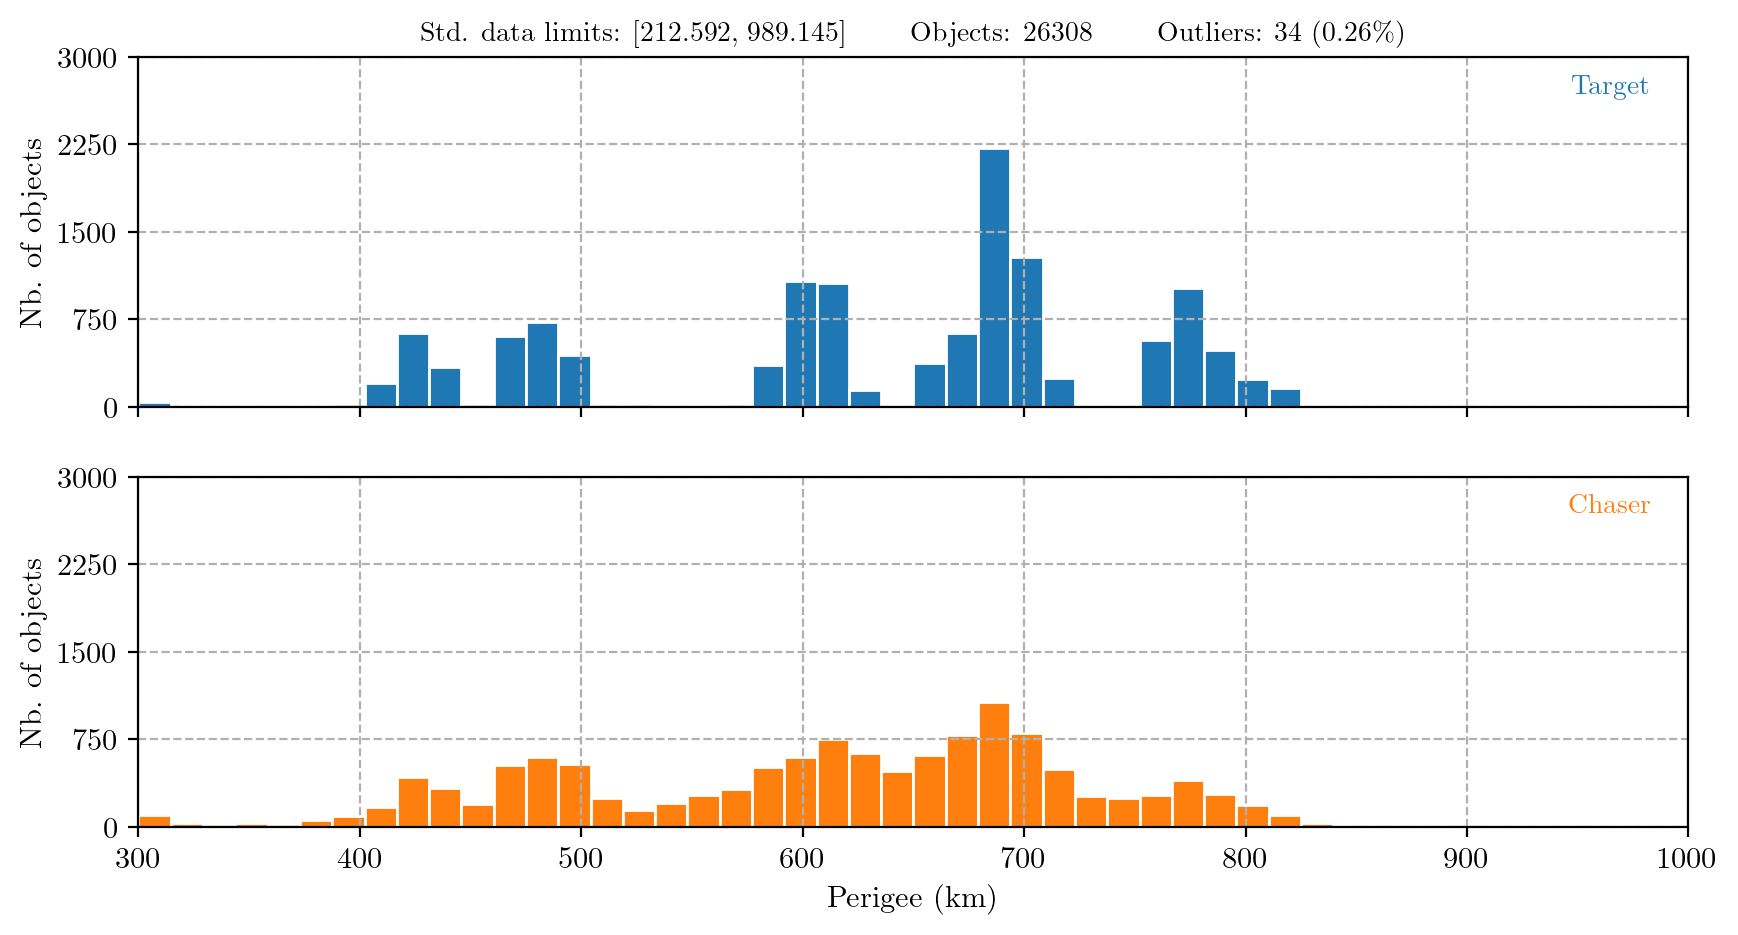

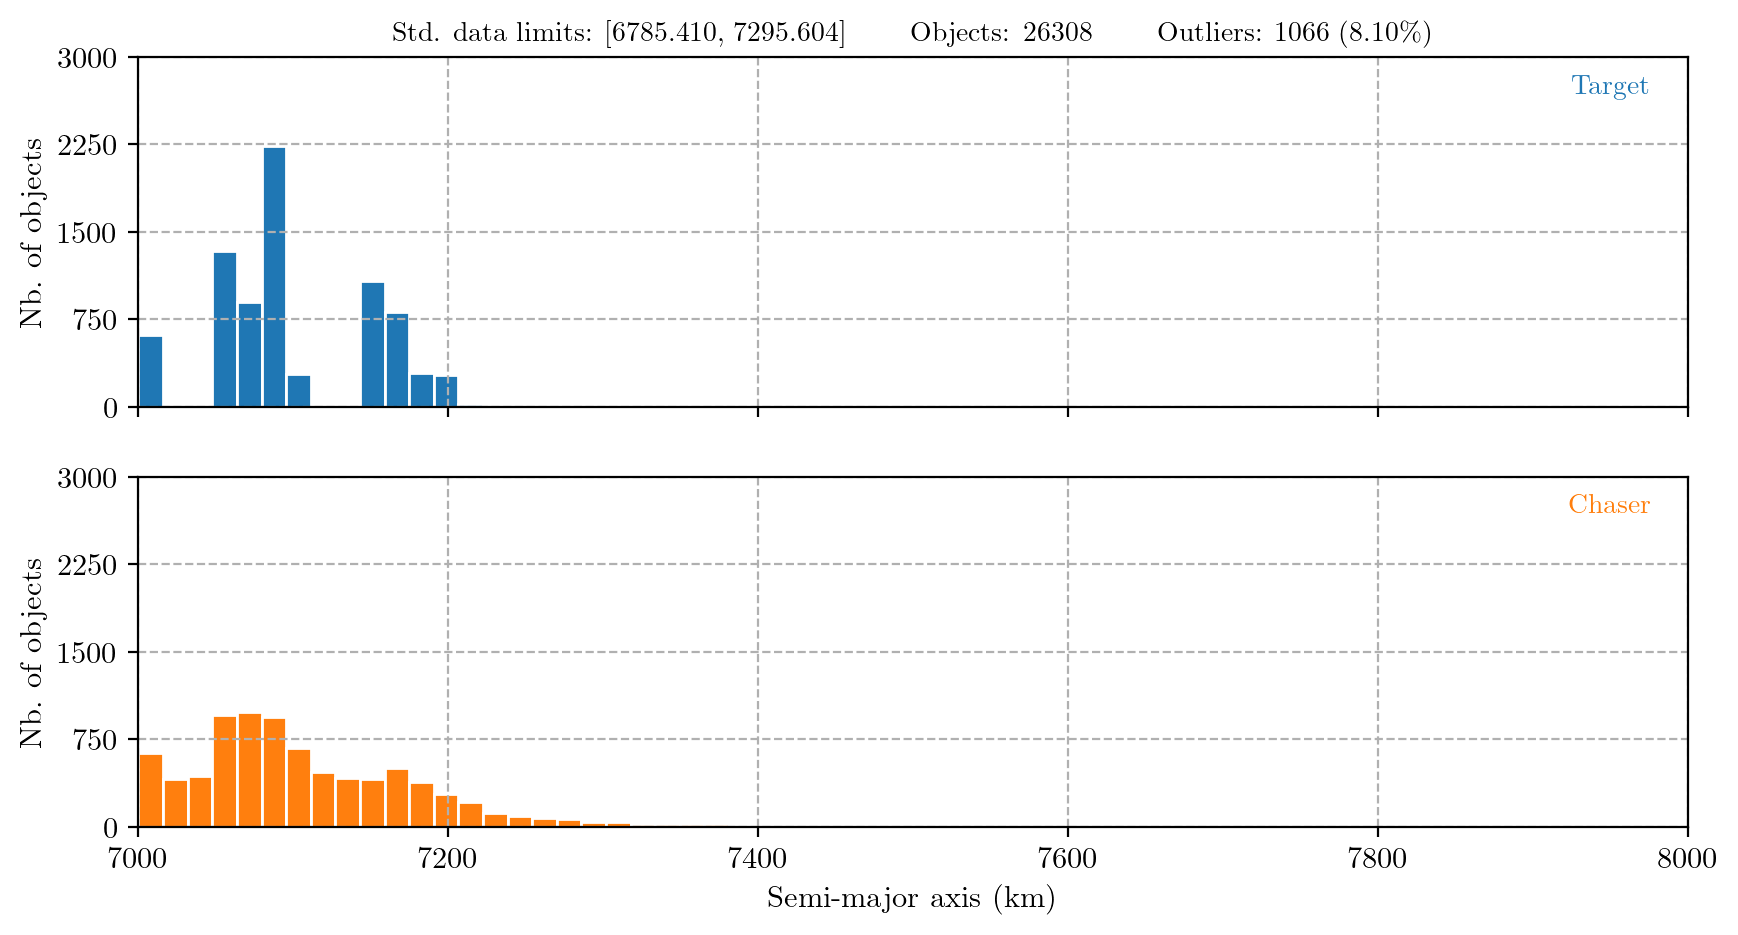

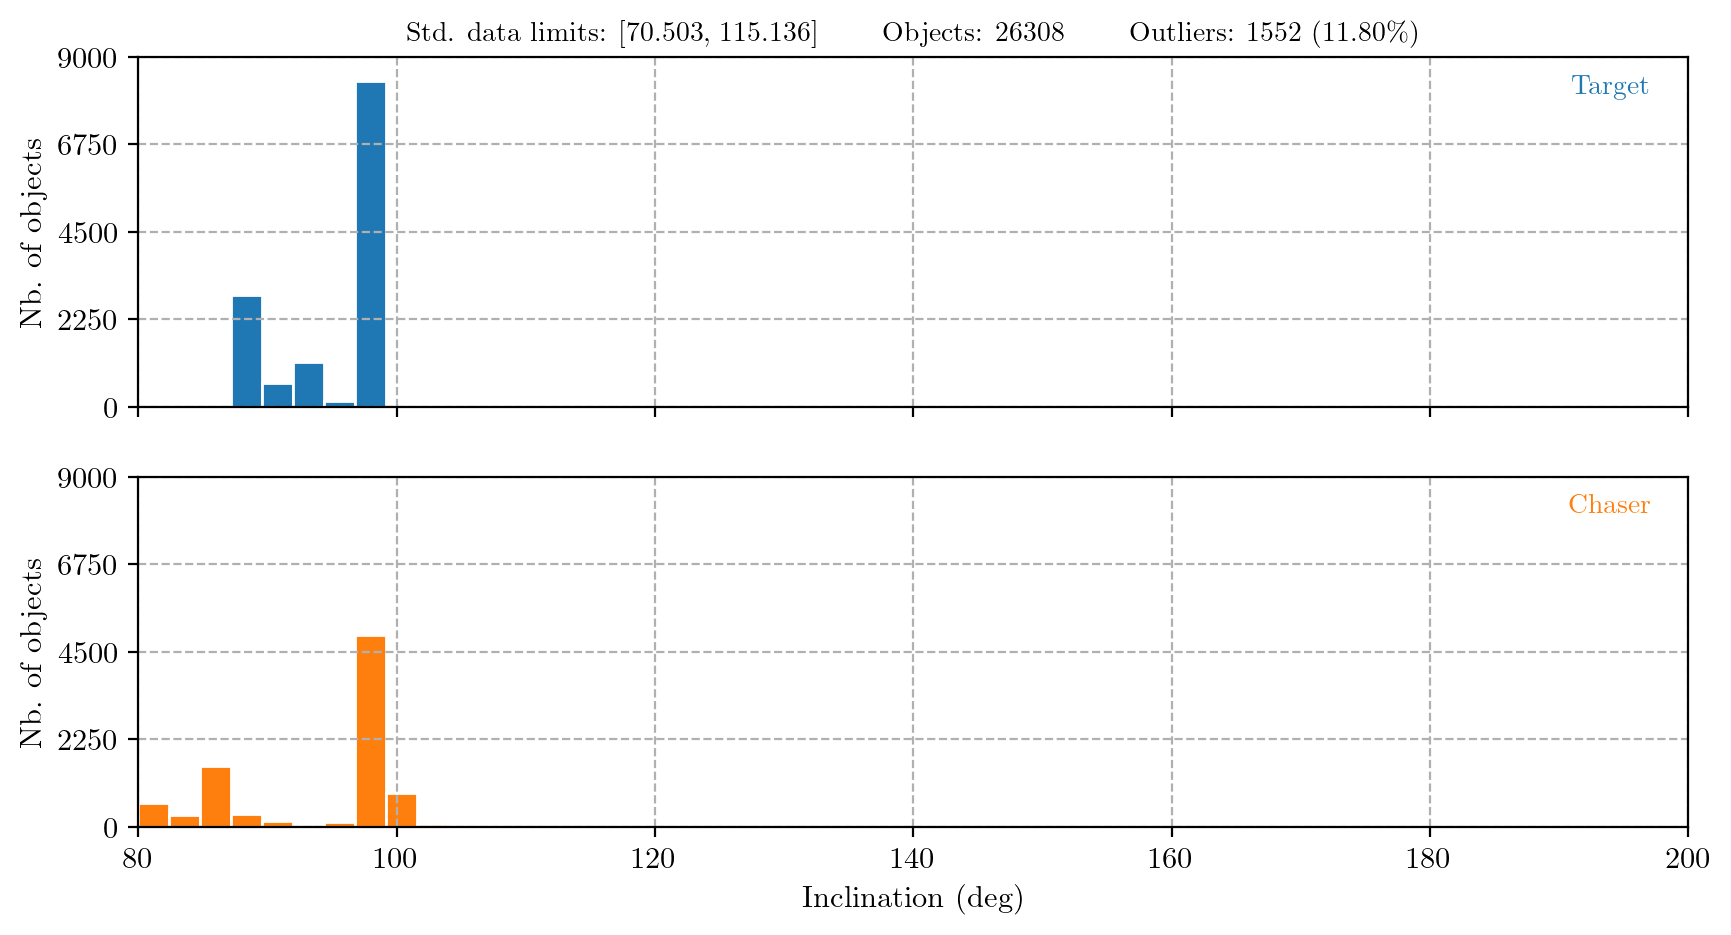

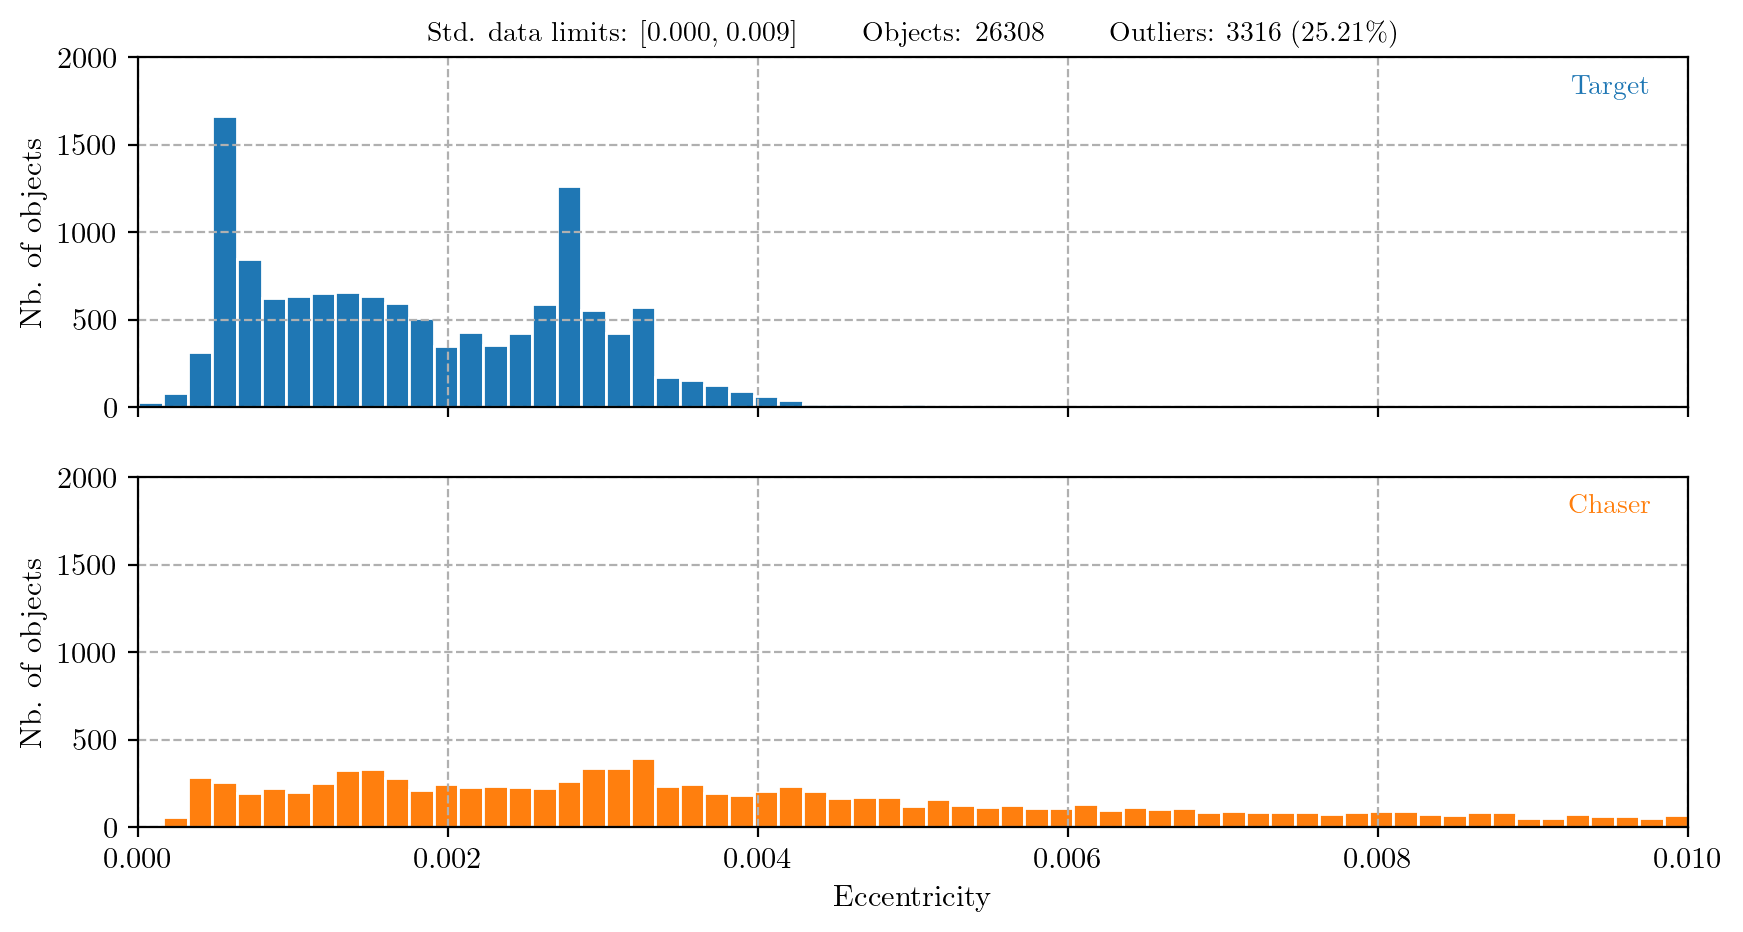

In [10]:
# Define orbital elements columns dictionary
keColumns = {'_h_per':   'Perigee (km)',
             '_j2k_sma': 'Semi-major axis (km)',
             '_j2k_inc': 'Inclination (deg)',
             '_j2k_ecc': 'Eccentricity', 
             }

# Iterate over all orbital elements
for eType, eName in keColumns.items():
    
    # Get orbital element data from both target and chaser objects to compute outliers boundaries
    data = pd.concat([df_lastCDM['t' + eType], df_lastCDM['c' + eType]]).to_numpy()
    
    # Calculate number of outliers for the orbital element
    std_lims = outliers_boundaries(data, 1.5)
    outliers = (data<std_lims[0]) | (data>std_lims[1])

    
    # Create figure object
    fig, axs = plt.subplots(nrows=2, figsize=(10, 5), squeeze=True, 
                            sharex=True, sharey=True)
    
    # Set plot title to indicate boundaries for standard data and outliers excluded from histogram.
    axs[0].set_title(r'Std. data limits: [{:.3f}, {:.3f}] \qquad Objects: {:d} \qquad Outliers: {:d} ({:.2f}\%)'\
                     .format(std_lims[0], std_lims[1], len(data),  
                             outliers.sum(), outliers.sum()/len(df_lastCDM.index)*100), 
                     fontsize=10)
    
    # Get minimum and maximum from data
    xlim = (round_by_mo(std_lims[0], 'floor'), round_by_mo(std_lims[1], 'ceil'))
    
    # Plot charts in subplot for both objects
    colors = ['tab:blue','tab:orange']
    
    # Calculate number of bins to plot histogram 
    bins = nbins(data[outliers==False], 'fd')['n']
    
    for i, obj in enumerate(['target', 'chaser']):
        
        
        # Plot histogram for the object and keplerian element.
        axs[i].hist(df_lastCDM[obj[0] + eType], bins = bins, 
                    color=colors[i], edgecolor='white', range=xlim, 
                    label=r'' + obj.capitalize())
        
        # Get the limits of Y-axis to reformat plot.
        ylim = (axs[i].get_ylim()[0], round_by_mo(axs[i].get_ylim()[1], 'ceil'))

        axs[i].grid(True, linestyle='--')
        axs[i].set_yticks(np.linspace(ylim[0],ylim[1],5))
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        axs[i].set_ylabel(r'Nb. of objects')
        
        # Plot label to identify which object the chart belongs to
        axs[i].text(0.95, 0.95, r'' + obj.capitalize(), size=10, ha='center', va='top', 
                    c=colors[i], transform=axs[i].transAxes, 
                    bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=-1))

    
    axs[1].set_xlabel(r'' + eName)
    
    plt.show()


# 3. - Probability Density Estimation for synthetic data generation

[Introduction to Probability Density Estimation](https://machinelearningmastery.com/probability-density-estimation/)

This analysis includes the two different ways to estimate the probability density associated to a given data distribution:

 - **Parametric**: the statistical distribution of the real data is described by an analytical and well-known statistical probability distribution by estimating the parameters implicit in the function.
 
 - **Non-parametric**: alternative method when the data distribution cannot be appropriately described analytically by a common probability distribution or cannot be easily made to fit the distribution (as it happens with multi-modal distributions). Among the multiple non-parametric methods available for Probability Density Estimation, the method used for estimating the probability density function of a continuous random variable in this analysis is the so-called Kernel Density Estimation (KDE).
 
The probability density function with wich all relevant continuous variables for which new data shall be generated, are fitted using both parametric and non-parametric methods and compared between each other to identify the one with the lowest Error Sum of Squares (SSE). For the parametric approach, a function is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). In the non-parametric approach the `KernelDensity` estimator is used from [Scikit-learn.org](https://scikit-learn.org/stable/modules/density.html) to fit a function to the continuous variable.

### 3.1. - Parametric Probability Density estimation




#### Finding the best statistical model to recreate real data distributions.

As described previously, for the parametric approach the function `find_best_distribution` is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). To do so, the algorithm retrieves all existing continuous distributions, tries to fit it to the real data, computes the SSE and compare to the best fit found so far. It returns the best statistical distribution which corresponds to the one with the lowest SSE.

#### Evaluation of  `miss_distance` using the parametric approach

Computing `find_best_distribution` function over all relevant continuous variables the results are the following:

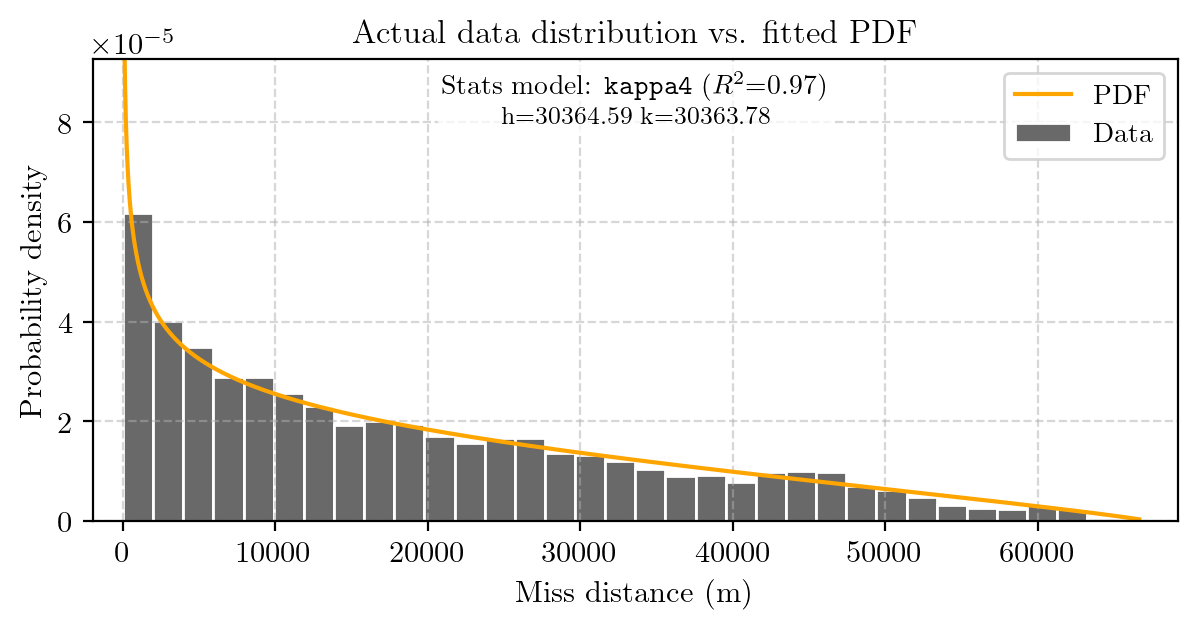

,distribution,r2_score
0,kappa4,0.972072
1,gausshyper,0.968552
2,beta,0.954073
3,johnsonsb,0.947271
4,nakagami,0.945349


In [39]:
# Set column name to study and remove outliers.
data = df_lastCDM['miss_distance']

bins = nbins(data, 'fd')['n']

# Find distribution that best fits the data
# distribution = fit_distribution(st.kappa4, data, bins = bins)
stdist, ranking = find_best_distribution(data, exclusion_list = ['studentized_range', 
                                                                 'levy_l_gen', 
                                                                 'levy_stable'])

# Create string with all parameters to print into the plot's title
text = r'Stats model: \texttt{' + stdist.name + r'} ' + '($R^2$={:.2f})'.format(stdist.r2_score()) + '\n' + \
            "  ".join(["\small {}={:0.2f}".format(k,v) \
            for k,v in zip(stdist.params['names'], stdist.params['values'])] )

    
# Print plot including histogram and distribution fitted
plot_scipy_pdf(data, stdist.pdf(), bins, **{'xlabel': 'Miss distance (m)', 'text':text})
ranking.head(5)

The continuous statistical model that best describes the `miss_distance` data distribution is `kappa4`. In order to compare side by side real data versus the synthetic data a histogram with the same number of events is generated using the trained model below: 

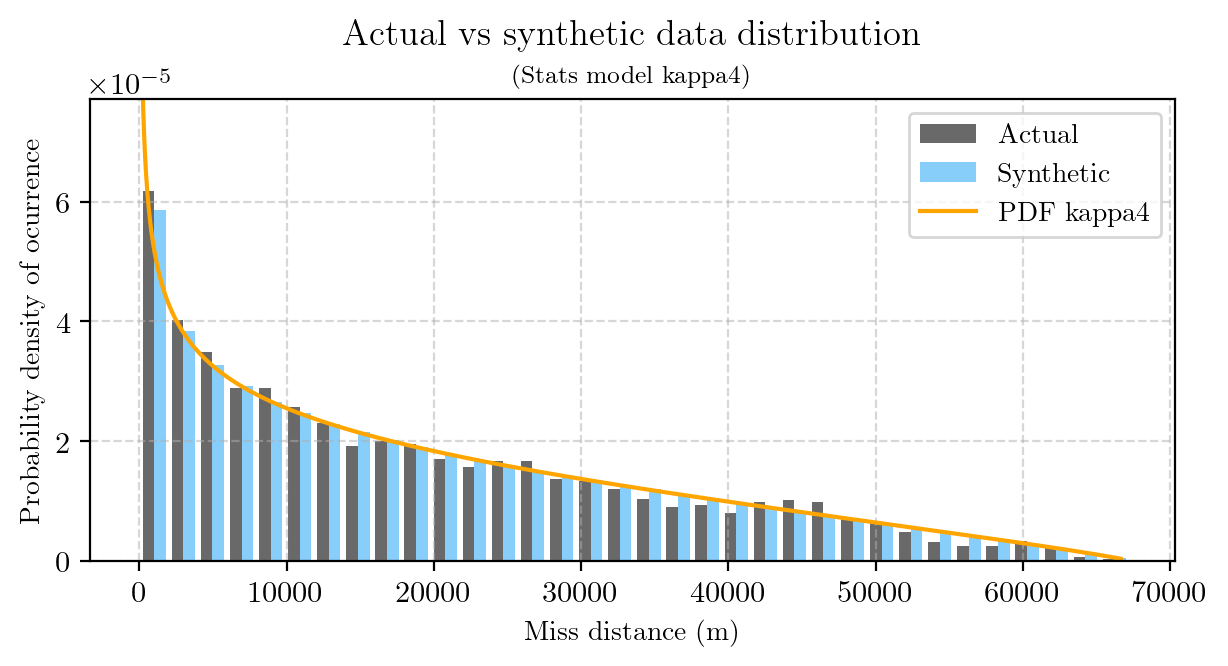

In [32]:
# Get best results parameters from the ranking dataset on miss_distance variable
stdist = FitScipyDistribution(data, st.kappa4)

# Generate random distribution using rvs function.
synthetic_data = stdist.dist.rvs(*stdist.params['arg_values'],
                                 loc   = stdist.params['loc'],
                                 scale = stdist.params['scale'], 
                                 size=int(5e6), random_state=1)

# Make Probability Density Function with distribution parameters 
pdf = stdist.pdf()

# Plot actual vs synthetic data for comparison
plt.figure(figsize=(7, 3))
n, bin_edges, patches = plt.hist([data, synthetic_data], density=True, bins = nbins(data, 'fd')['n'], 
                                 label=['Actual', 'Synthetic'], color=['dimgrey','lightskyblue'])
plt.plot(stdist.pdf().index.to_numpy(), stdist.pdf().values, 
         lw=1.5, color = "orange", label="PDF " + stdist.name)
plt.ylim(0, np.max(n[0,:])*1.25)
plt.ylabel(r'Probability density of ocurrence', fontsize=10)
plt.xlabel(r'Miss distance (m)', fontsize=10)
plt.title(r'Actual vs synthetic data distribution'+ '\n' +'\small (Stats model ' + stdist.name + ')')
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.legend(loc='best', fontsize=10)

plt.show()

### 3.2. - Non-Parametric Probability Density Estimation using KDE

The keplerian elements that describle the orbits for both targets and chasers objects shows multimodal distributions that cannot be described by continuous stats models. As a consequence, the Non-parametric Probability Density Estimation (PDE) with KDE shall be used in order to fit a model that allows for synthetic data generation with a realistic distribution.

 - [Histograms and KDE by Michael Lerner](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)
 - [Kernel Density Estimation in Python by Jake VanderPlas](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)

In [ ]:
# Define function to compute KDE
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.array(x).reshape(-1,1))
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)



def r2_pdf_pda(data, bandwidth):
    """PDF vs actual probability density correlation evaluation using R2"""
    # Compute histogram for the actual data distribution in order to get the actual probability density (pda)
    pda, bin_edges = np.histogram(data, bins=nbins(data, 'fd')['n'], density=True)
    bin_centers = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0
    
    pdf = kde_sklearn(data, bin_centers, kernel='gaussian', bandwidth=bandwidth)
    
    return {'pda':pda, 'pdf':pdf, 'r2_score': r2_score(pda,pdf)}

In [ ]:
# Define orbital elements columns dictionary
keColumns = {'t_h_per':   {'bandwidths': np.linspace(1,10,50),      'label': 'Perigee (Km)'},
             't_j2k_sma': {'bandwidths': np.linspace(1,10,50),      'label': 'Semi-major axis (Km)'} ,
             't_j2k_inc': {'bandwidths': np.linspace(0.1,0.4,50),   'label': 'Inclination (deg)', } ,
             't_j2k_ecc': {'bandwidths': np.linspace(1e-5,1e-4,50), 'label': 'Eccentricity',} 
             }
for keColumn, keInfo in keColumns.items():
    data = df_lastCDM[keColumn].to_numpy().reshape(-1,1)

    # Calculate limits of standard data for visualization purposes
    std_lims = outliers_boundaries(data, 1.5)
    xlim = (round_by_mo(std_lims[0], 'floor', 0.5), round_by_mo(std_lims[1], 'ceil', 0.5))

    data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

    # Iterate through different bandwidths to compute its SSE.
    bandwidths = keInfo['bandwidths']

    r2_all   = np.zeros_like(bandwidths)
    r2_train = np.zeros_like(bandwidths)
    r2_test  = np.zeros_like(bandwidths)

    for i, bandwidth in enumerate(bandwidths):

        # Compute histogram for the actual data distribution in order to get the actual probability density (pda)
        r2_all[i]   = r2_pdf_pda(data, bandwidth)['r2_score']
        r2_train[i] = r2_pdf_pda(data_train, bandwidth)['r2_score']
        r2_test[i]  = r2_pdf_pda(data_test, bandwidth)['r2_score']


    r2_avg = (r2_all+r2_train+r2_test)/3
    best_bw = bandwidths[r2_avg==np.max(r2_avg)][0]
    
    # Compute the PDF with the KDE upon a given array of points
    x_grid = np.linspace(round_by_mo(np.min(data), 'floor'), round_by_mo(np.max(data), 'ceil'), 1000)
    pdf = kde_sklearn(data, x_grid, kernel='gaussian', bandwidth=best_bw)


    # Create the figure object
    fig = plt.figure(figsize=(11,3))

    # Create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 4], wspace=0.25)

    # Plot R2 scores for the three sets of data: all, train, test and the average of all.
    ax0 = fig.add_subplot(spec[0])
    ax0.plot(bandwidths, r2_all, 'b--', lw=1.5, label=r'All')
    ax0.plot(bandwidths, r2_train, 'r--', lw=1.5, label=r'Train')
    ax0.plot(bandwidths, r2_test, 'g--', lw=1.5, label=r'Test')
    ax0.plot(bandwidths, r2_avg, 'k-', lw=1.5, label=r'Average')
    ax0.plot(best_bw, np.max(r2_avg), 'ro', lw=1.5)


    ax0.set_title(r'KDE bandwidth selection',fontsize=10)
    ax0.set_ylabel(r'Coefficient of determination ($R^2$)', fontsize=10)
    ax0.set_xlabel(r'Bandwidth', fontsize=10)
    ax0.set_xlim(bandwidths[0], bandwidths[-1])
    ax0.set_ylim(0.5, 1.1)
    ax0.legend(loc='lower right', fontsize=8)

    t = ax0.text(0.5, 0.975, 
                 r'\small ($BW_{best}$=' + '{:.2e}'.format(best_bw) + 
                 r' / $R^{2}_{avg}$=' + '{:.2f})'.format(np.max(r2_avg)), 
                 size=10, ha='center', va='top', \
                 c='black', transform=ax0.transAxes, \
                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=-1))


    # Plot PD estimated by the KDE vs the histogram
    ax1 = fig.add_subplot(spec[1])
    kde = KernelDensity(bandwidth=best_bw, kernel='gaussian').fit(data)
    
    synthetic_data = kde.sample(n_samples=int(5e6), random_state=1)
    # print(synthetic_data)
    # ax1.hist(data, density=True, alpha=0.5, color='gray', edgecolor='white', 
    #          bins = nbins(data, 'fd'), label=r'Histogram')
    
    ax1.hist([data.flatten(), synthetic_data.flatten()], density=True,
             bins = nbins(data, 'fd'), 
             label=['Actual', 'Synthetic'], 
             color=['dimgrey','lightskyblue'])
    
    ax1.plot(x_grid, pdf, '-', color='orange', lw=1.5, label=r'PDF ($BW_{best}$=' + '{:.2e})'.format(best_bw))

    ax1.set_title(r'Actual probability density vs estimated', fontsize=10)
    ax1.set_ylabel(r'Probability density', fontsize=10)
    ax1.set_xlabel(r'' + keInfo['label'])
    ax1.set_xlim(xlim)

    ax1.legend(loc='best', fontsize=8)

    ax0.grid(True, linestyle="dashed", alpha=0.5)
    ax1.grid(True, linestyle="dashed", alpha=0.5)

    fig.suptitle(r'Data distribution analysis', fontsize=14, y=1.05)

    plt.show()


Research paper sections:
- Abstract
- Introduction
- Literature review
- Methodology
- Results & Discussion
- Conclusion
- References

In [ ]:
colors = list(mcolors.TABLEAU_COLORS.values())

df_kmeans = pd.DataFrame(columns = ['variable','n_clusters', 
                                    'clusters_centers', 'clusters_limits'])
# Run through both type of objects
for keColumn, keLabel in keColumns.items():

    # Get the data upon which the clustering shall be done
    data = np.array(df_lastCDM['t' + keColumn]).reshape(-1, 1)

    # Get number of bins used in a global histogram for better readability
    bins = nbins(data, 'fd')

    # Use Silhouette method to compute optimal number of clusters

    potential_clusters = np.arange(2, 11,1)
    silhouette_avg = []
    for n_clusters in potential_clusters:

        # Initialise the clusterer object
        clusterer = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

        # Calculate silhouette score and append it to the array
        silhouette_avg.append(silhouette_score(data, clusterer.labels_))

    # Get maximum Silhouette score that indicate optimal number of clusters
    max_silhouette_score = np.max(silhouette_avg)
    n_clusters = np.min(potential_clusters[silhouette_avg==max_silhouette_score])

    # Use KMeans algorithm to identify all different clusters in 1D
    clusterer = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    
    # Re-label clusters to be sorted by orbit region from lower to upper
    # in order to visually identify cluster labels from plots
    clusters_centers = clusterer.cluster_centers_.flatten()
    clusters_labels = clusterer.predict(clusters_centers.reshape(-1,1))
    
    
    labels  = clusterer.labels_.flatten()

    custom_labels = np.zeros_like(labels)
    cluster_limits={}
    for c, center in enumerate(np.sort(clusters_centers)):
        label = clusters_labels[clusters_centers==center]
        custom_labels[labels == label] = c
    

    # Create the figure object
    fig = plt.figure(figsize=(10,2.5))

    # Create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 3], wspace=0.25)

    # Plot Silhouette chart
    ax0 = fig.add_subplot(spec[0])
    ax0.plot(potential_clusters, silhouette_avg,'kx--')
    ax0.plot(n_clusters, max_silhouette_score, 'ro')
    ax0.set_ylabel(r'Silhouette score')
    ax0.set_xlabel(r'Nb. of clusters')
    ax0.set_ylim(0.5,1)
    ax0.set_xticks(potential_clusters)

    # Plot histogram grouped by clusters
    ax1 = fig.add_subplot(spec[1])
    N, bins, patches = ax1.hist(data, bins = bins, edgecolor = 'white')
    ax1.set_ylabel(r'Nb. of events')
    ax1.set_xlabel(r'' + keLabel)
    
    bins_per_cluster = dict(zip(clusters_labels, [0]*len(clusters_labels)))
    print(bins_per_cluster)

    for i in range(len(patches)):

        # Get the cluster to which the bin belongs to
        bin_cluster = custom_labels[(data<=bins[i+1]).flatten() & (data>bins[i]).flatten()]
        
        if len(bin_cluster)>0: 
            bins_per_cluster[bin_cluster[0]] += 1
            # Change histogram bar color if it belongs to a cluster
            patches[i].set_facecolor(colors[np.max(bin_cluster)])

    ax0.grid(True, linestyle="dashed", alpha=0.5)
    ax1.grid(True, linestyle="dashed", alpha=0.5)
    
    fig.suptitle(r'Data distribution cluster analysis for \texttt{t' + keColumn + '}' + '\n'
                 '\small (Optimum number of clusters = ' + str(n_clusters) + ')', 
                 fontsize=12, y=1.05)
    
    plt.show()
    print(bins_per_cluster)
    
    break

#### Probability Density Estimation using Scikit-Learn

In [ ]:
data = df_lastCDM['miss_distance'].to_numpy().reshape(-1,1)


grid = GridSearchCV(KernelDensity(kernel='exponential'),
                    {'bandwidth': np.linspace(120, 130, 20)},
                    cv=5) # 20-fold cross-validation
grid.fit(data)
print(grid.best_params_)